In [17]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you follow football right?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Rao")) # type: ignore
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the venue of FIFA World Cup 26 ", name="Rao")) # type: ignore

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you follow football right?
================================ Human Message =================================
Name: Rao

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Rao

I want to learn about the venue of FIFA World Cup 26 


In [25]:
import os, getpass
from langchain_groq import ChatGroq

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

llm = ChatGroq(model="openai/gpt-oss-20b")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [26]:
result

AIMessage(content='### The 2026 FIFA World Cup – “Venue of the 26th World Cup”\n\n> **Why it matters**  \n> The 2026 edition is the 26th FIFA World Cup (the 26th *tournament*), and it will be the first time the competition is staged in **three countries**.  \n> The host trio –\u202f**United States, Canada, and Mexico** – will together provide **20 stadiums** across 20 cities, covering every major region of North America.\n\n---\n\n## 1. Host Countries & Cities\n\n| Country | Host Cities (20 total) | Stadiums |\n|---------|------------------------|----------|\n| **United States** | Atlanta, Charlotte, Dallas, Detroit, Houston, Kansas City, Los\u202fAngeles, Miami, New\u202fYork/New\u202fJersey, Philadelphia, Phoenix, Pittsburgh, San\u202fFrancisco, Seattle, St.\u202fLouis, **(and 16 in total)** | 16 stadiums |\n| **Canada** | Toronto, Vancouver | 2 stadiums |\n| **Mexico** | Mexico City, Guadalajara | 2 stadiums |\n\n> **Note** – The 20 venues are spread across the 20 host cities.  \n\n

In [27]:
result.response_metadata

{'token_usage': {'completion_tokens': 4497,
  'prompt_tokens': 122,
  'total_tokens': 4619,
  'completion_time': 4.66666823,
  'prompt_time': 0.00823447,
  'queue_time': 0.04299278,
  'total_time': 4.6749027},
 'model_name': 'openai/gpt-oss-20b',
 'system_fingerprint': 'fp_e99e93f2ac',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

In [41]:
def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([add, multiply])

In [42]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 3", name="Rao")])

In [43]:
tool_call.tool_calls # type: ignore

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'fc_3c5af42c-42f0-4c7c-af38-e220f8b5e8ef',
  'type': 'tool_call'}]

In [44]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [45]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState): # type: ignore
    pass

In [36]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on Fifa World Cup 2026.", name="Rao")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='e2ec9f97-3efe-4a56-b7c7-eb1f1c8dbe7e'),
 HumanMessage(content="I'm looking for information on Fifa World Cup 2026.", additional_kwargs={}, response_metadata={}, name='Rao', id='abbe9baf-db54-4c84-b4f2-860305ee80e0'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='9670bac6-1276-4117-9536-f4751c784cfb')]

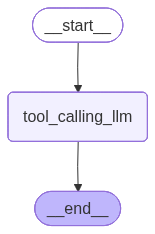

In [37]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")}) # type: ignore
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you today?


In [50]:
messages = graph.invoke({"messages": HumanMessage(content="Add 2 and 3")}) # type: ignore
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 2 and 3
================================== Ai Message ==================================
Tool Calls:
  add (fc_509f157e-2815-4789-a9b5-394197c0c7b6)
 Call ID: fc_509f157e-2815-4789-a9b5-394197c0c7b6
  Args:
    a: 2
    b: 3


In [48]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")}) # type: ignore
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_116695e0-10f1-473e-a658-f3ded7c0f4c4)
 Call ID: fc_116695e0-10f1-473e-a658-f3ded7c0f4c4
  Args:
    a: 2
    b: 3


In [51]:
messages = graph.invoke({"messages": HumanMessage(content="Tell me about Fifa World Cup 2026")}) # type: ignore
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me about Fifa World Cup 2026
================================== Ai Message ==================================

**FIFA World Cup 2026 – A Quick Overview**

| Topic | Details |
|-------|---------|
| **Edition** | 23rd FIFA World Cup (first under the 48‑team format) |
| **Host Countries** | United States, Canada, Mexico (joint bid) |
| **Dates** | 8 June – 29 July 2026 (exact dates still to be confirmed by FIFA) |
| **Venues** | 16 stadiums across 12 cities: 10 in the U.S., 4 in Canada, 2 in Mexico. |
| **Key Cities** | Los Angeles, New York/New Jersey, Dallas, Atlanta, Mexico City, Toronto, Montreal, Vancouver, Edmonton, Calgary, Ottawa, and others. |
| **Format** | • 48 teams total. <br>• 16 groups of 3 teams (each team plays 2 matches). <br>• Top two teams from each group advance to a 32‑team knockout stage. |
| **Qualification** | 47 spots are allocated to the 6 continental confederations (UEFA, CON